In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy.optimize import minimize

from src.data.load_dataset import load_sensilla_sta

In [2]:
def sensilla_covariance_matrix(dim, sampling_rate, duration, lowcut, highcut, decay_coef=np.inf, scale=1):
    '''
    Generates the (dim x dim) covariance matrix for Gaussain Process inspired by the STAs 
    of mechanosensory neurons in insect halteres. Decaying sinusoids.
    
    $$k(t, t') = \mathbb{E}[w(t)^T w(t')] =  \sum_{j=0}^{dim-1} \lambda_j \cos{\dfrac{i 2 \pi j (t-t')}{dim}} * exp((- \|t- N - 1\| + \|t'- N - 1\|) / decay_coef ** 2) $$
    $$ \lambda_j = \begin{cases} 1 & lowcut \leq highcut \\ 0 & otherwise \end{cases}$$

    Parameters
    ----------

    dim: int
        dimension of each random weight
        
    sampling_rate : int
        Sampling rate of the weights
    
    lowcut: int
        low end of the frequency band in Hz

    highcut : int
        high end of the frequency band in Hz
        
    decay_coef : float, default=np.inf
        controls the window of the weights in seconds
        With default value, the weights do not decay
    
    scale: float
        Normalization factor for Tr norm of cov matrix
    
    Returns
    -------
    C : array-like of shape (dim, dim) 
        Covariance matrix w/ Tr norm = scale * dim
    '''


    assert dim == int(sampling_rate * duration), "The dim of weights does not match sampling rate * duration"

    # time grid
    grid = np.arange(0, duration, 1 / sampling_rate)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # cosine part
    low_idx = int(duration * lowcut)
    high_idx = int(duration * highcut)
    C_cos = np.zeros((dim, dim))
    for k in range(low_idx, high_idx):
        C_cos += np.cos(2 * np.pi * k * diff / duration)

    # exponential part
    C_exp = np.exp(((xx - duration) + (yy - duration)) / decay_coef)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * dim / np.trace(C))
    C += 1e-5 * np.eye(dim)
    return C

def sensilla_weights(num_weights, sampling_rate, duration, dim, lowcut, highcut, decay_coef=np.inf, scale=1, seed=None):
    """
    Generates random weights with tuning similar to mechanosensory 
    neurons found in insect halteres and wings.

    Parameters
    ----------

    num_weights: int
        Number of random weights

    dim : int
        dim of each random weight

    sampling_rate : int
        Sampling rate of the weights
    
    lowcut: int
        low end of the frequency band in Hz

    highcut : int
        high end of the frequency band in Hz
        
    decay_coef : float, default=np.inf
        controls the window of the weights in seconds
        With default value, the weights do not decay
    
    seed : int, default=None
        Used to set the seed when generating random weights.
    
    Returns
    -------

    W : array-like of shape (num_weights, dim)
        Matrix of Random weights.
    """
    assert dim == int(sampling_rate * duration), "The dim of weights does not match sampling rate * duration"
    np.random.seed(seed)
    C = sensilla_covariance_matrix(dim, sampling_rate, duration, lowcut, highcut, decay_coef, scale)
    W = np.random.multivariate_normal(np.zeros(dim), cov=C, size=num_weights)
    return W

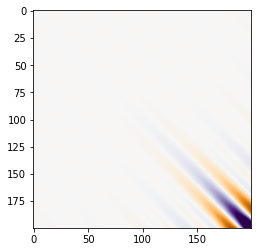

In [3]:
sampling_rate, duration, lowcut, highcut, decay_coef, scale = 2000, 0.1, 30, 80, 0.022, 1
dim = int(sampling_rate * duration)
C = sensilla_covariance_matrix(dim, sampling_rate, duration, lowcut, highcut, decay_coef=decay_coef, scale=1)

fig = plt.figure()
plt.imshow(C, cmap='PuOr')
plt.clim(-5, 5)

In [4]:
sta, samp_rate, samp_window = load_sensilla_sta()
num_cells, dim = sta.shape

In [5]:
# compute data covariance
cov_data = sta.T @ sta
cov_data *= cov_data.shape[1] / np.trace(cov_data)

def sensilla_covariance_matrix_to_minimize(dim, sampling_rate, duration, lowcut, highcut, decay_coef, scale=1): 
    ''' Changed to a linear programming problem so that it can be minimized easily.
    Find lowcut and highcut real numbers and divide into equally spaced intervals.
    The number of intervals equals to their difference'''
    
    assert dim == int(sampling_rate * duration), "The dim of weights does not match sampling rate * duration"

    # time grid
    grid = np.arange(0, duration, 1 / sampling_rate)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    
    # cosine part
    C_cos = np.zeros((dim, dim))
    for k in np.arange(lowcut, highcut, 1 / duration):
        C_cos += np.cos(2 * np.pi * k * diff)

    # exponential part
    C_exp = np.exp(((xx - duration) + (yy - duration)) / decay_coef)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * dim / np.trace(C))
    C += 1e-5 * np.eye(dim)
    return C

# find params that minimize frobenius norm difference between data and covariance model
def frob_norm_diff(x):
    cov_model = sensilla_covariance_matrix_to_minimize(dim, samp_rate, samp_window, 
                                                       lowcut=x[0], highcut=x[1], decay_coef=x[2], scale=1)
    return la.norm(cov_model - cov_data)

x0 = [55, 100, 0.01]
cons = ({'type': 'ineq', 'fun': lambda x:  x[1] - x[0]})
min_diff = minimize(frob_norm_diff, x0, method='COBYLA', constraints=cons, tol=1e-4)
lowcut_min, highcut_min, decay_coef_min = min_diff.x
print("Optimal params: lowcut=%0.3f, highcut=%0.3f, decay_coef=%0.3f" %(lowcut_min, highcut_min, decay_coef_min))

KeyboardInterrupt: 

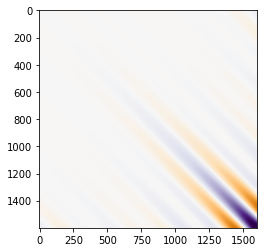

In [183]:
sampling_rate, duration = samp_rate, samp_window
lowcut, highcut, decay_coef, scale = int(lowcut_min), int(highcut_min), decay_coef.copy(), 1
dim = int(sampling_rate * duration)
C = sensilla_covariance_matrix(dim, sampling_rate, duration, lowcut, highcut, decay_coef=decay_coef, scale=1)

fig = plt.figure()
plt.imshow(C, cmap='PuOr')
plt.clim(-5, 5)

In [165]:
from src.models.weights import sensilla_covariance_matrix, sensilla_weights

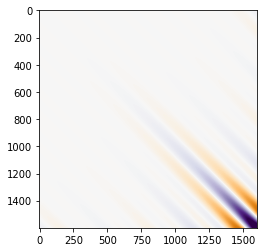

In [166]:
W = sensilla_covariance_matrix(1600, 3, 8, 487, scale=1)

fig = plt.figure()
plt.imshow(W, cmap='PuOr')
plt.clim(-5, 5)

In [178]:
duration = 0.1

In [179]:
np.arange(lowcut, highcut, 1 / duration)

array([ 75.,  85.,  95., 105., 115., 125., 135., 145., 155., 165., 175.,
       185., 195.])

In [6]:
# previous version

def sensilla_covariance_matrix(dim, lowcut, highcut, decay_coef=np.inf, scale=1):
    '''
    Generates the (dim x dim) covariance matrix for Gaussain Process inspired by the STAs 
    of mechanosensory neurons in insect halteres. Decaying sinusoids.
    
    $$k(t, t') = \mathbb{E}[w(t)^T w(t')] =  \sum_{j=0}^{dim-1} \lambda_j \cos{\dfrac{i 2 \pi j (t-t')}{dim}} * exp((- \|t- N - 1\| + \|t'- N - 1\|) / decay_coef ** 2) $$
    $$ \lambda_j = \begin{cases} 1 & lowcut \leq highcut \\ 0 & otherwise \end{cases}$$

    Parameters
    ----------

    dim: int
        dimension of each random weight
    
    lowcut: int
        low end of the frequency band filter

    highcut : int
        high end of the frequency band filter
        
    decay_coef : float, default=np.inf
        controls the how fast the random features decay
        With default value, the weights do not decay
    
    scale: float
        Normalization factor for Tr norm of cov matrix
    
    Returns
    -------
    C : array-like of shape (dim, dim) 
        Covariance matrix w/ Tr norm = scale * dim
    '''
    
    lamda = np.zeros(dim)
    lamda[lowcut:highcut] = 1

    grid = np.arange(0, dim)
    yy, xx = np.meshgrid(grid, grid)
    diff = xx - yy

    # sinusoidal part
    C_cos = np.zeros((dim, dim))
    for j in range(lowcut, highcut):
        C_cos += lamda[j] * np.cos(2 * np.pi * j * diff / dim)

    # exponential part
    C_exp = np.exp(((xx - dim) + (yy - dim)) / decay_coef)

    # final covariance matrix
    C = C_cos * C_exp 
    C *= (scale * dim / np.trace(C))
    C += 1e-5 * np.eye(dim)
    return C

def sensilla_weights(num_weights, dim, lowcut, highcut, decay_coef=np.inf, scale=1, seed=None):
    """
    Generates random weights with tuning similar to mechanosensory 
    neurons found in insect halteres and wings.

    Parameters
    ----------

    num_weights: int
        Number of random weights

    dim : int
        dim of each random weight

    lowcut: int
        Low end of the frequency band. 

    highcut: int
        High end of the frequency band.
        
    decay_coef : float, default=np.inf
        controls the how fast the random features decay
        with default value, the weights do not decay
    
    seed : int, default=None
        Used to set the seed when generating random weights.
    
    Returns
    -------

    W : array-like of shape (num_weights, dim)
        Matrix of Random weights.
    """
    np.random.seed(seed)
    C = sensilla_covariance_matrix(dim, lowcut, highcut, decay_coef, scale)
    W = np.random.multivariate_normal(np.zeros(dim), cov=C, size=num_weights)
    return W